VALIDATION STRATEGY DEEP DIVE

Total clean receivals: 122383
Date range: 2004-06-15 to 2024-12-19

[1] ANALYZING CURRENT RANDOM 80/20 SPLIT
--------------------------------------------------------------------------------
Training dates: 11 months
Date range: 2024-01-01 to 2024-11-01
Forecast horizons: [7, 30, 60, 90, 150]
Active rm_ids in 2024: 60

Generating training samples for 50 rm_ids...
Generated 2565 training samples
Samples with target > 0: 1779 (69.4%)

[2] SIMULATING RANDOM 80/20 SPLIT (Current Approach)
--------------------------------------------------------------------------------
Training set: 2052 samples
Validation set: 513 samples

--- Temporal Distribution in Random Split ---

Training set date range:
  Min date: 2024-01-01
  Max date: 2024-11-01
  Unique months: 11

Validation set date range:
  Min date: 2024-01-01
  Max date: 2024-11-01
  Unique months: 11

⚠️  Random split mixes all time periods!
  Training has samples from: 11 months
  Validation has samples from:

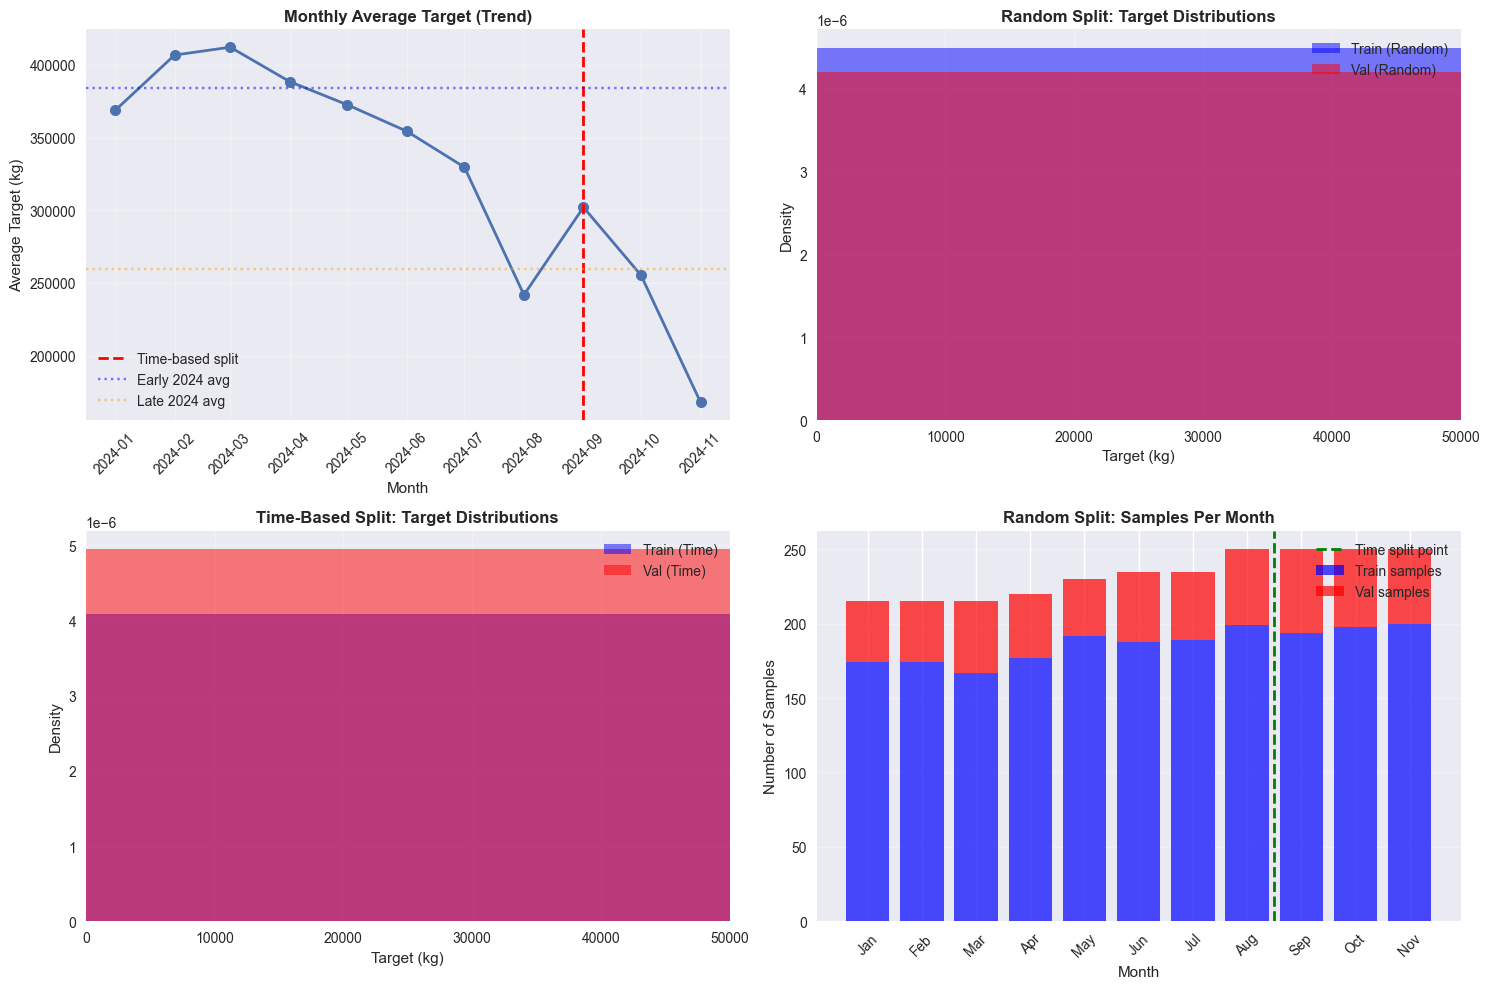

In [1]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8')

# Load data
receivals = pd.read_csv('./Project_materials/data/kernel/receivals.csv')
purchase_orders = pd.read_csv('./Project_materials/data/kernel/purchase_orders.csv')
prediction_mapping = pd.read_csv('./Project_materials/data/prediction_mapping.csv')

# Convert dates
receivals['date_arrival'] = pd.to_datetime(receivals['date_arrival'], utc=True).dt.tz_localize(None)
purchase_orders['delivery_date'] = pd.to_datetime(purchase_orders['delivery_date'], utc=True).dt.tz_localize(None)
purchase_orders['created_date_time'] = pd.to_datetime(purchase_orders['created_date_time'], utc=True).dt.tz_localize(None)
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'])
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'])

print("="*80)
print("VALIDATION STRATEGY DEEP DIVE")
print("="*80)

# Clean data
receivals = receivals[receivals['net_weight'] > 0]
receivals = receivals[receivals['rm_id'].notna()]
receivals = receivals.sort_values('date_arrival')

print(f"\nTotal clean receivals: {len(receivals)}")
print(f"Date range: {receivals['date_arrival'].min().date()} to {receivals['date_arrival'].max().date()}")

# ============================================================================
# PART 1: UNDERSTAND CURRENT RANDOM SPLIT BEHAVIOR
# ============================================================================
print("\n[1] ANALYZING CURRENT RANDOM 80/20 SPLIT")
print("-"*80)

# Create a mini version of training data to analyze
train_dates = pd.date_range(start='2024-01-01', end='2024-11-30', freq='MS')
forecast_horizons = [7, 30, 60, 90, 150]

print(f"Training dates: {len(train_dates)} months")
print(f"Date range: {train_dates[0].date()} to {train_dates[-1].date()}")
print(f"Forecast horizons: {forecast_horizons}")

training_data = []
active_rm_ids = receivals[receivals['date_arrival'] >= '2024-01-01']['rm_id'].unique()
print(f"Active rm_ids in 2024: {len(active_rm_ids)}")

# Generate subset of training data for analysis (use all dates, sample rm_ids)
sample_rm_ids = active_rm_ids[:50]  # Use first 50 active rm_ids for speed

print(f"\nGenerating training samples for {len(sample_rm_ids)} rm_ids...")

for train_date in train_dates:
    for rm_id in sample_rm_ids:
        hist = receivals[
            (receivals['rm_id'] == rm_id) &
            (receivals['date_arrival'] < train_date)
        ]
        
        if len(hist) == 0:
            continue
        
        cutoff_365 = train_date - timedelta(days=365)
        recent_365 = hist[hist['date_arrival'] >= cutoff_365]
        
        if len(recent_365) > 0:
            total_365 = recent_365['net_weight'].sum()
            count_365 = len(recent_365)
        else:
            total_365 = count_365 = 0
        
        for horizon in forecast_horizons:
            forecast_end = train_date + timedelta(days=horizon)
            
            actual = receivals[
                (receivals['rm_id'] == rm_id) &
                (receivals['date_arrival'] >= train_date) &
                (receivals['date_arrival'] <= forecast_end)
            ]
            target = actual['net_weight'].sum()
            
            training_data.append({
                'rm_id': rm_id,
                'train_date': train_date,
                'forecast_horizon': horizon,
                'month': train_date.month,
                'quarter': train_date.quarter,
                'total_weight_365d': total_365,
                'count_365d': count_365,
                'target': target
            })

train_df = pd.DataFrame(training_data)
print(f"Generated {len(train_df)} training samples")
print(f"Samples with target > 0: {(train_df['target'] > 0).sum()} ({(train_df['target'] > 0).sum() / len(train_df) * 100:.1f}%)")

# ============================================================================
# PART 2: SIMULATE RANDOM SPLIT
# ============================================================================
print("\n[2] SIMULATING RANDOM 80/20 SPLIT (Current Approach)")
print("-"*80)

# Random split like in your current code
X = train_df[['rm_id', 'forecast_horizon', 'month', 'quarter', 'total_weight_365d', 'count_365d']]
y = train_df['target']

X_train_rand, X_val_rand, y_train_rand, y_val_rand = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Add back the train_date for analysis
train_rand_df = X_train_rand.copy()
train_rand_df['target'] = y_train_rand
train_rand_df['train_date'] = train_df.loc[X_train_rand.index, 'train_date'].values

val_rand_df = X_val_rand.copy()
val_rand_df['target'] = y_val_rand
val_rand_df['train_date'] = train_df.loc[X_val_rand.index, 'train_date'].values

print(f"Training set: {len(train_rand_df)} samples")
print(f"Validation set: {len(val_rand_df)} samples")

# Analyze temporal distribution
print("\n--- Temporal Distribution in Random Split ---")
print("\nTraining set date range:")
print(f"  Min date: {train_rand_df['train_date'].min().date()}")
print(f"  Max date: {train_rand_df['train_date'].max().date()}")
print(f"  Unique months: {train_rand_df['train_date'].dt.to_period('M').nunique()}")

print("\nValidation set date range:")
print(f"  Min date: {val_rand_df['train_date'].min().date()}")
print(f"  Max date: {val_rand_df['train_date'].max().date()}")
print(f"  Unique months: {val_rand_df['train_date'].dt.to_period('M').nunique()}")

# Check if validation has samples from ALL months
train_months = set(train_rand_df['train_date'].dt.to_period('M'))
val_months = set(val_rand_df['train_date'].dt.to_period('M'))

print(f"\n⚠️  Random split mixes all time periods!")
print(f"  Training has samples from: {len(train_months)} months")
print(f"  Validation has samples from: {len(val_months)} months")
print(f"  Overlap: {len(train_months & val_months)} months")

# Target statistics
print("\n--- Target Statistics (Random Split) ---")
print(f"Training target mean: {train_rand_df['target'].mean():.2f}")
print(f"Validation target mean: {val_rand_df['target'].mean():.2f}")
print(f"Difference: {((val_rand_df['target'].mean() - train_rand_df['target'].mean()) / train_rand_df['target'].mean() * 100):+.1f}%")

# ============================================================================
# PART 3: SIMULATE TIME-BASED SPLIT
# ============================================================================
print("\n[3] SIMULATING TIME-BASED SPLIT (Better Approach)")
print("-"*80)

# Time-based split: Train on Jan-Aug, Validate on Sep-Nov
cutoff_date = pd.to_datetime('2024-09-01')

train_time_mask = train_df['train_date'] < cutoff_date
val_time_mask = train_df['train_date'] >= cutoff_date

train_time_df = train_df[train_time_mask].copy()
val_time_df = train_df[val_time_mask].copy()

print(f"Training set (before {cutoff_date.date()}): {len(train_time_df)} samples")
print(f"Validation set (>= {cutoff_date.date()}): {len(val_time_df)} samples")

print("\n--- Temporal Distribution in Time-Based Split ---")
print("\nTraining set date range:")
print(f"  Min date: {train_time_df['train_date'].min().date()}")
print(f"  Max date: {train_time_df['train_date'].max().date()}")
print(f"  Unique months: {train_time_df['train_date'].dt.to_period('M').nunique()}")

print("\nValidation set date range:")
print(f"  Min date: {val_time_df['train_date'].min().date()}")
print(f"  Max date: {val_time_df['train_date'].max().date()}")
print(f"  Unique months: {val_time_df['train_date'].dt.to_period('M').nunique()}")

print(f"\n✅ Time-based split ensures NO temporal leakage!")
print(f"  Training: {train_time_df['train_date'].min().date()} to {train_time_df['train_date'].max().date()}")
print(f"  Validation: {val_time_df['train_date'].min().date()} to {val_time_df['train_date'].max().date()}")
print(f"  Gap: {(val_time_df['train_date'].min() - train_time_df['train_date'].max()).days} days")

# Target statistics
print("\n--- Target Statistics (Time-Based Split) ---")
print(f"Training target mean: {train_time_df['target'].mean():.2f}")
print(f"Validation target mean: {val_time_df['target'].mean():.2f}")
print(f"Difference: {((val_time_df['target'].mean() - train_time_df['target'].mean()) / train_time_df['target'].mean() * 100):+.1f}%")

# ============================================================================
# PART 4: COMPARE FEATURE DISTRIBUTIONS
# ============================================================================
print("\n[4] COMPARING FEATURE DISTRIBUTIONS")
print("-"*80)

print("\n--- Random Split ---")
print("Training features:")
print(f"  total_weight_365d: mean={train_rand_df['total_weight_365d'].mean():.0f}, std={train_rand_df['total_weight_365d'].std():.0f}")
print(f"  count_365d: mean={train_rand_df['count_365d'].mean():.1f}, std={train_rand_df['count_365d'].std():.1f}")

print("Validation features:")
print(f"  total_weight_365d: mean={val_rand_df['total_weight_365d'].mean():.0f}, std={val_rand_df['total_weight_365d'].std():.0f}")
print(f"  count_365d: mean={val_rand_df['count_365d'].mean():.1f}, std={val_rand_df['count_365d'].std():.1f}")

print("\n--- Time-Based Split ---")
print("Training features:")
print(f"  total_weight_365d: mean={train_time_df['total_weight_365d'].mean():.0f}, std={train_time_df['total_weight_365d'].std():.0f}")
print(f"  count_365d: mean={train_time_df['count_365d'].mean():.1f}, std={train_time_df['count_365d'].std():.1f}")

print("Validation features:")
print(f"  total_weight_365d: mean={val_time_df['total_weight_365d'].mean():.0f}, std={val_time_df['total_weight_365d'].std():.0f}")
print(f"  count_365d: mean={val_time_df['count_365d'].mean():.1f}, std={val_time_df['count_365d'].std():.1f}")

# ============================================================================
# PART 5: ANALYZE WHAT 2025 PREDICTION LOOKS LIKE
# ============================================================================
print("\n[5] UNDERSTANDING THE 2025 PREDICTION TASK")
print("-"*80)

print(f"\nTest task: Predict from {prediction_mapping['forecast_start_date'].iloc[0].date()} to various dates in 2025")
print(f"Test prediction date: {prediction_mapping['forecast_start_date'].iloc[0].date()}")
print(f"Max forecast end date: {prediction_mapping['forecast_end_date'].max().date()}")

# Check what data we have BEFORE 2025-01-01 (what the model sees)
data_before_2025 = receivals[receivals['date_arrival'] < '2025-01-01']
print(f"\nData available BEFORE 2025-01-01:")
print(f"  Total receivals: {len(data_before_2025)}")
print(f"  Last delivery: {data_before_2025['date_arrival'].max().date()}")
print(f"  Date range: {data_before_2025['date_arrival'].min().date()} to {data_before_2025['date_arrival'].max().date()}")

# Compare to what training sees
latest_train_date = train_df['train_date'].max()
print(f"\nLatest training date in training data: {latest_train_date.date()}")
print(f"Gap between latest training and 2025 prediction: {(pd.to_datetime('2025-01-01') - latest_train_date).days} days")

# ============================================================================
# PART 6: KEY INSIGHT - TEMPORAL TREND
# ============================================================================
print("\n[6] ANALYZING TEMPORAL TREND (The Real Problem)")
print("-"*80)

# Group by month and calculate average target
monthly_avg = train_df.groupby(train_df['train_date'].dt.to_period('M'))['target'].mean().reset_index()
monthly_avg.columns = ['month', 'avg_target']
monthly_avg['month'] = monthly_avg['month'].dt.to_timestamp()

print("\nMonthly average target values:")
print(monthly_avg.to_string(index=False))

# Calculate trend
early_months = monthly_avg[monthly_avg['month'] < '2024-07-01']['avg_target'].mean()
late_months = monthly_avg[monthly_avg['month'] >= '2024-07-01']['avg_target'].mean()

print(f"\nTrend analysis:")
print(f"  Early 2024 (Jan-Jun) avg target: {early_months:.2f} kg")
print(f"  Late 2024 (Jul-Nov) avg target: {late_months:.2f} kg")
print(f"  Change: {((late_months - early_months) / early_months * 100):+.1f}%")

if late_months < early_months:
    print(f"\n⚠️  DECLINING TREND DETECTED!")
    print(f"  If random split is used, model trains on mix of high and low periods")
    print(f"  Model won't learn that 2025 predictions should be lower")
    print(f"  Result: Over-prediction → high quantile loss (80% penalty!)")

# ============================================================================
# PART 7: SIMULATE WHAT HAPPENS WITH EACH VALIDATION
# ============================================================================
print("\n[7] IMPACT ON MODEL PREDICTIONS")
print("-"*80)

print("\nRandom Split Logic:")
print("  - Model sees samples from ALL months (Jan-Nov) in training")
print("  - Model sees samples from ALL months (Jan-Nov) in validation")
print("  - Model learns: 'average across all 2024' ≈ high prediction")
print("  - Validation score: GOOD (because val also has high months)")
print("  - 2025 test score: BAD (if 2025 continues decline)")

print("\nTime-Based Split Logic:")
print("  - Model sees samples from Jan-Aug in training (higher values)")
print("  - Model sees samples from Sep-Nov in validation (lower values)")
print("  - Model learns: must predict lower for later periods")
print("  - Validation score: May be WORSE (harder task)")
print("  - 2025 test score: BETTER (more realistic)")

print("\n💡 KEY INSIGHT:")
print("  Random split optimizes for the WRONG objective!")
print("  Time-based split is harder but teaches the RIGHT lesson")

# ============================================================================
# VISUALIZATION
# ============================================================================
print("\n[8] CREATING VISUALIZATIONS")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot 1: Monthly trend with split points
ax1 = axes[0, 0]
ax1.plot(monthly_avg['month'], monthly_avg['avg_target'], marker='o', linewidth=2, markersize=8)
ax1.axvline(cutoff_date, color='red', linestyle='--', linewidth=2, label='Time-based split')
ax1.axhline(early_months, color='blue', linestyle=':', alpha=0.5, label='Early 2024 avg')
ax1.axhline(late_months, color='orange', linestyle=':', alpha=0.5, label='Late 2024 avg')
ax1.set_title('Monthly Average Target (Trend)', fontsize=12, fontweight='bold')
ax1.set_xlabel('Month')
ax1.set_ylabel('Average Target (kg)')
ax1.legend()
ax1.grid(alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45)

# Plot 2: Distribution comparison - Random split
ax2 = axes[0, 1]
ax2.hist(train_rand_df['target'], bins=50, alpha=0.5, label='Train (Random)', density=True, color='blue')
ax2.hist(val_rand_df['target'], bins=50, alpha=0.5, label='Val (Random)', density=True, color='red')
ax2.set_title('Random Split: Target Distributions', fontsize=12, fontweight='bold')
ax2.set_xlabel('Target (kg)')
ax2.set_ylabel('Density')
ax2.set_xlim(0, 50000)
ax2.legend()
ax2.grid(alpha=0.3)

# Plot 3: Distribution comparison - Time-based split
ax3 = axes[1, 0]
ax3.hist(train_time_df['target'], bins=50, alpha=0.5, label='Train (Time)', density=True, color='blue')
ax3.hist(val_time_df['target'], bins=50, alpha=0.5, label='Val (Time)', density=True, color='red')
ax3.set_title('Time-Based Split: Target Distributions', fontsize=12, fontweight='bold')
ax3.set_xlabel('Target (kg)')
ax3.set_ylabel('Density')
ax3.set_xlim(0, 50000)
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Temporal coverage
ax4 = axes[1, 1]
months = train_df['train_date'].dt.to_period('M').unique()
months_sorted = sorted([m.to_timestamp() for m in months])

train_rand_months = train_rand_df['train_date'].dt.to_period('M').value_counts()
val_rand_months = val_rand_df['train_date'].dt.to_period('M').value_counts()

x = range(len(months_sorted))
train_counts = [train_rand_months.get(pd.Period(m, freq='M'), 0) for m in months_sorted]
val_counts = [val_rand_months.get(pd.Period(m, freq='M'), 0) for m in months_sorted]

ax4.bar(x, train_counts, alpha=0.7, label='Train samples', color='blue')
ax4.bar(x, val_counts, alpha=0.7, label='Val samples', color='red', bottom=train_counts)
ax4.axvline(7.5, color='green', linestyle='--', linewidth=2, label='Time split point')
ax4.set_title('Random Split: Samples Per Month', fontsize=12, fontweight='bold')
ax4.set_xlabel('Month')
ax4.set_ylabel('Number of Samples')
ax4.set_xticks(x)
ax4.set_xticklabels([m.strftime('%b') for m in months_sorted], rotation=45)
ax4.legend()
ax4.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('validation_strategy_comparison.png', dpi=300, bbox_inches='tight')
print("Saved visualization to 'validation_strategy_comparison.png'")

# ============================================================================
# SUMMARY AND RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("SUMMARY & RECOMMENDATIONS")
print("="*80)

print("\n📊 FINDINGS:")
print(f"  1. Random split mixes {len(train_months & val_months)} months between train/val")
print(f"  2. Time-based split has ZERO temporal overlap (clean separation)")
print(f"  3. Target declined {abs((late_months - early_months) / early_months * 100):.1f}% from early to late 2024")
print(f"  4. Random split: train and val have similar distributions")
print(f"  5. Time-based split: val distribution is SHIFTED (more realistic)")

print("\n🎯 WHY YOUR MODEL SCORES 9600:")
print("  - You train on random mix of high (early 2024) and low (late 2024) periods")
print("  - Model learns to predict 'average of all 2024'")
print("  - 2025 test likely continues declining trend")
print("  - Model over-predicts → 80% penalty from quantile loss → high score")

print("\n✅ RECOMMENDED ACTIONS:")
print("  1. Replace random split with time-based split:")
print("     train_mask = train_df['train_date'] < pd.to_datetime('2024-09-01')")
print("     X_train = train_df[train_mask][feature_cols]")
print("     X_val = train_df[~train_mask][feature_cols]")
print("\n  2. EXPECT validation score to get worse initially (that's good!)")
print("     - Harder validation = more realistic = better test score")
print("\n  3. Add trend features to help model detect decline:")
print("     - momentum: total_90d / total_180d")
print("     - acceleration: (recent_rate - old_rate)")
print("\n  4. Consider conservative adjustment:")
print("     - Multiply predictions by 0.90 for 2025")
print("     - Or use alpha=0.15 instead of 0.20")

print("\n" + "="*80)